In [84]:
import pycaret
import pandas as pd

In [85]:
# อ่านไฟล์ CSV
data = pd.read_csv('../export_data/filtered_data_3_best.csv')

In [86]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data = data.asfreq('D')  # 'D' สำหรับรายวัน

In [87]:
data.tail(5)

,humidity,pm_10,pm_2_5,pm_2_5_sp,temperature
timestamp,,,,,
2025-02-07 07:00:00,70.933952,34.743259,29.321219,26.166471,28.271927
2025-02-08 07:00:00,69.348548,30.654249,26.000000,22.380675,28.385596
2025-02-09 07:00:00,69.916384,28.971065,24.616898,20.976852,28.373742
2025-02-10 07:00:00,71.226336,30.652667,25.856981,22.374574,28.251201
2025-02-11 07:00:00,68.159624,32.532955,27.522727,24.120455,28.693799


In [88]:
# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data[data.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data[data.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")


row = data.loc["2023-09-30 07:00:00"]
row

แถวที่มีค่าหายไปก่อนเติม:
                     humidity  pm_10  pm_2_5  pm_2_5_sp  temperature
timestamp                                                           
2023-09-30 07:00:00       NaN    NaN     NaN        NaN          NaN
ไม่มีค่าหายไปแล้ว


humidity       82.889367
pm_10          60.525519
pm_2_5         53.415241
pm_2_5_sp      69.527667
temperature    29.219760
Name: 2023-09-30 07:00:00, dtype: float64

In [89]:
data = data[['temperature']]

In [90]:
data["year"] = data.index.year
data["month"] = data.index.month
data["day"] = data.index.day
data["day_of_week"] = data.index.dayofweek  # 0 = Monday, 6 = Sunday
data["week_of_year"] = data.index.isocalendar().week  # ค่าจะเป็น int64

In [91]:
# สมมติว่า data มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data["season"] = data.index.month.map(assign_season)
data['season'] = data['season'].map(season_mapping)

In [92]:
data["is_weekend"] = data.index.dayofweek.isin([5, 6]).astype(int)

In [93]:
import pandas as pd
import numpy as np

# สมมุติว่ามี DataFrame data ที่มีข้อมูลอยู่แล้ว
# เพิ่มฟีเจอร์ day_of_year
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['day_of_year'] = data['date'].dt.dayofyear

# เพิ่มฟีเจอร์ month_sin และ month_cos
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

lag_size = 7
for i in range(1,lag_size+1):
    data[f'temperature_lag_{i}'] = data['temperature'].shift(i)


In [94]:
# data["temp_diff"] = data["temperature"].diff()

In [95]:
data.columns

Index(['temperature', 'year', 'month', 'day', 'day_of_week', 'week_of_year',
       'season', 'is_weekend', 'date', 'day_of_year', 'month_sin', 'month_cos',
       'day_of_week_sin', 'day_of_week_cos', 'temperature_lag_1',
       'temperature_lag_2', 'temperature_lag_3', 'temperature_lag_4',
       'temperature_lag_5', 'temperature_lag_6', 'temperature_lag_7'],
      dtype='object')

In [96]:
data_filtered = data.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

<Axes: xlabel='timestamp'>

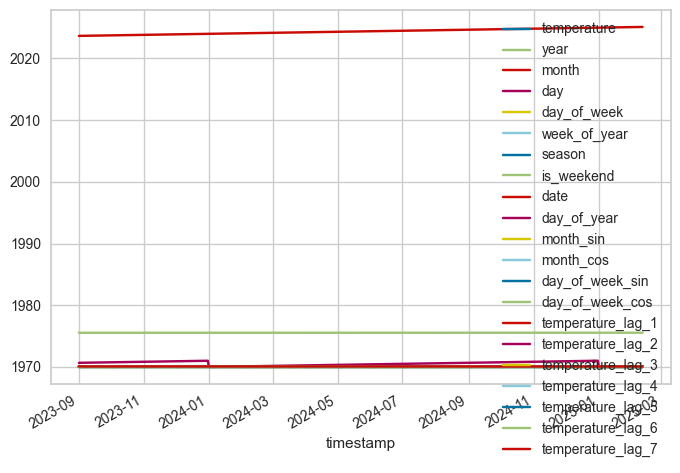

In [97]:
data_filtered.plot()

In [98]:
# สมมติว่า data มีจำนวนวันทั้งหมด
total_data = len(data_filtered)

# จำนวนวันที่ต้องการเป็น test data
test_days = 7

# คำนวณสัดส่วนของ 30 วันในข้อมูลทั้งหมด
test_size = test_days / total_data
test_size

0.013207547169811321

In [99]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_filtered, test_size=test_size, shuffle=False)

In [100]:
train_data.shape

(523, 21)

In [101]:
test_data.shape

(7, 21)

In [102]:
test_data.head(1)

,temperature,year,month,day,day_of_week,week_of_year,season,is_weekend,date,day_of_year,...,month_cos,day_of_week_sin,day_of_week_cos,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_4,temperature_lag_5,temperature_lag_6,temperature_lag_7
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-05 07:00:00,28.32745,2025,2,5,2,6,0,0,2025-02-05,36,...,0.5,0.974928,-0.222521,27.775432,28.644544,27.68389,27.31541,27.336718,27.512931,27.242726


In [103]:
test_data.tail(1)

,temperature,year,month,day,day_of_week,week_of_year,season,is_weekend,date,day_of_year,...,month_cos,day_of_week_sin,day_of_week_cos,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_4,temperature_lag_5,temperature_lag_6,temperature_lag_7
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-11 07:00:00,28.693799,2025,2,11,1,7,0,0,2025-02-11,42,...,0.5,0.781831,0.62349,28.251201,28.373742,28.385596,28.271927,28.579177,28.32745,27.775432


In [104]:
test_data.columns

Index(['temperature', 'year', 'month', 'day', 'day_of_week', 'week_of_year',
       'season', 'is_weekend', 'date', 'day_of_year', 'month_sin', 'month_cos',
       'day_of_week_sin', 'day_of_week_cos', 'temperature_lag_1',
       'temperature_lag_2', 'temperature_lag_3', 'temperature_lag_4',
       'temperature_lag_5', 'temperature_lag_6', 'temperature_lag_7'],
      dtype='object')

In [105]:
# from pycaret.time_series import *
from pycaret.regression import RegressionExperiment
exp1 = RegressionExperiment()
exp1.setup(data=train_data, target='temperature', session_id=123, fold=12, iterative_imputation_iters=100, remove_outliers = True)
# iterative_imputation_iters=100, remove_outliers = True

,Description,Value
0,Session id,123
1,Target,temperature
2,Target type,Regression
3,Original data shape,"(523, 21)"
4,Transformed data shape,"(504, 23)"
5,Transformed train set shape,"(347, 23)"
6,Transformed test set shape,"(157, 23)"
7,Numeric features,19
8,Date features,1
9,Preprocess,True


In [106]:
# compare baseline models
best = exp1.compare_models(n_select=15)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.7738,1.0362,1.0041,0.5071,0.0346,0.0276,0.0175
ridge,Ridge Regression,0.7718,1.0474,1.0084,0.4993,0.0347,0.0276,0.0183
huber,Huber Regressor,0.7715,1.0521,1.0129,0.4920,0.0348,0.0275,0.0250
omp,Orthogonal Matching Pursuit,0.8166,1.1222,1.0481,0.4712,0.0360,0.0291,0.0192
rf,Random Forest Regressor,0.8137,1.1476,1.0567,0.4517,0.0364,0.0291,0.0575
et,Extra Trees Regressor,0.8191,1.1755,1.0655,0.4391,0.0367,0.0293,0.0425
ada,AdaBoost Regressor,0.8475,1.1873,1.0778,0.4300,0.0371,0.0302,0.0275
knn,K Neighbors Regressor,0.8381,1.2118,1.0883,0.4223,0.0374,0.0299,0.0250
gbr,Gradient Boosting Regressor,0.8556,1.2220,1.0921,0.4109,0.0376,0.0306,0.0333
en,Elastic Net,0.9261,1.3158,1.1345,0.3910,0.0389,0.0329,0.0183


In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
# model_1 = exp1.create_model('rf')
model_1 = exp1.create_model('dt')
# model_2 = exp1.create_model('et')
# model_3 = exp1.create_model('br')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.2045,2.3345,1.5279,-0.2629,0.0515,0.0415
1,1.1251,2.0172,1.4203,-0.0259,0.0484,0.0395
2,1.0880,2.1072,1.4516,0.2232,0.0504,0.0387
3,1.1680,2.2309,1.4936,0.2503,0.0512,0.0414
4,0.7843,1.1883,1.0901,0.4231,0.0381,0.0279
5,1.3620,2.7585,1.6609,-0.5816,0.0578,0.0490
6,1.0540,1.7606,1.3269,0.3878,0.0469,0.0379
7,1.2794,2.3672,1.5386,-0.1633,0.0531,0.0460
8,1.0223,1.8646,1.3655,0.3353,0.0469,0.0370


In [ ]:
# exp1.evaluate_model(model_1)

In [ ]:
predictions = exp1.predict_model(model_1, data=test_data)
predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.9449,1.5833,1.2583,-0.8455,0.0442,0.0348


,year,month,day,day_of_week,week_of_year,season,is_weekend,date,day_of_year,month_sin,...,day_of_week_cos,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_4,temperature_lag_5,temperature_lag_6,temperature_lag_7,temperature,prediction_label
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-13 07:00:00,2025,1,13,0,3,2,0,2025-01-13,13,0.5,...,1.000000,25.434973,28.357460,28.945705,28.383165,28.921543,29.145098,28.825508,25.997341,27.903372
2025-01-14 07:00:00,2025,1,14,1,3,2,0,2025-01-14,14,0.5,...,0.623490,25.997341,25.434973,28.357460,28.945705,28.383165,28.921543,29.145098,26.780884,26.639114
2025-01-15 07:00:00,2025,1,15,2,3,2,0,2025-01-15,15,0.5,...,-0.222521,26.780884,25.997341,25.434973,28.357460,28.945705,28.383165,28.921543,27.146723,26.681078
2025-01-16 07:00:00,2025,1,16,3,3,2,0,2025-01-16,16,0.5,...,-0.900969,27.146723,26.780884,25.997341,25.434973,28.357460,28.945705,28.383165,24.990604,26.681078
2025-01-17 07:00:00,2025,1,17,4,3,2,0,2025-01-17,17,0.5,...,-0.900969,24.990604,27.146723,26.780884,25.997341,25.434973,28.357460,28.945705,27.221664,28.185730


In [ ]:
predict_v = predictions['prediction_label']
predict_v.head()

timestamp
2025-01-13 07:00:00    27.903372
2025-01-14 07:00:00    26.639114
2025-01-15 07:00:00    26.681078
2025-01-16 07:00:00    26.681078
2025-01-17 07:00:00    28.185730
Freq: D, Name: prediction_label, dtype: float64

In [ ]:
real = test_data['temperature']
real.head()

timestamp
2025-01-13 07:00:00    25.997341
2025-01-14 07:00:00    26.780883
2025-01-15 07:00:00    27.146722
2025-01-16 07:00:00    24.990604
2025-01-17 07:00:00    27.221665
Freq: D, Name: temperature, dtype: float64

# ทำนาย 1 วันข้างหน้า ต้องทำนายเผื่อ 2 วัน

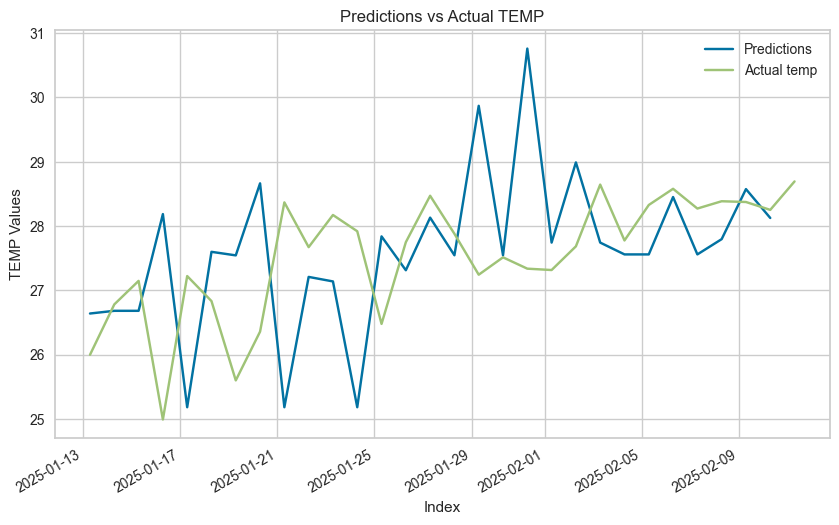

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result = pd.concat([predict_v.shift(-1), test_data['temperature']], axis=1)
result.columns = ['Predictions', 'Actual temp']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual TEMP')
plt.xlabel('Index')
plt.ylabel('TEMP Values')

# แสดงกราฟ
plt.show()

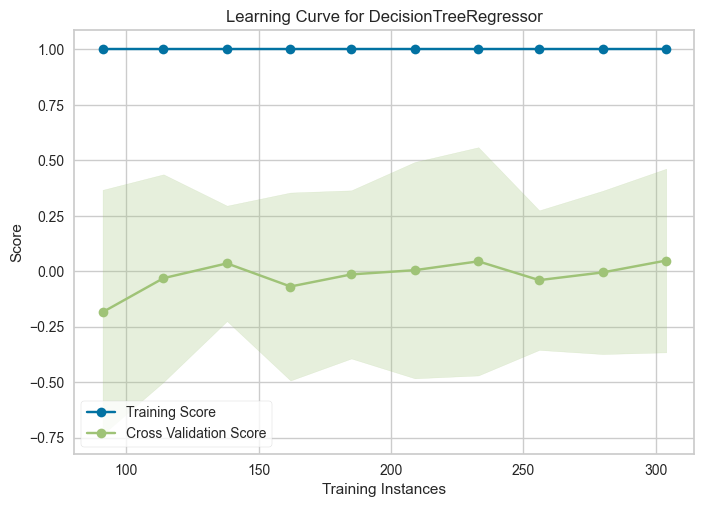

In [ ]:
exp1.plot_model(model_1, 'learning')

In [ ]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_true = test_data["temperature"][:"2025-2-10"]
y_pred = predict_v.shift(-1).dropna(axis=0)

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = (1 - (mae / mean_actual)) * 100  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage

R² Score: -1.8256
Mean Absolute Error (MAE): 1.1315
Root Mean Squared Error (RMSE): 1.5402
Accuracy: 95.88%


In [ ]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Extract actual values and predicted values
y_true = test_data["temperature"][:"2025-2-10"]
y_pred = predict_v.shift(-1).dropna(axis=0)

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

R² Score: -1.8256
Mean Absolute Error (MAE): 1.1315
Root Mean Squared Error (RMSE): 1.5402
Mean Absolute Percentage Error (MAPE): 4.17%
Accuracy: 95.83%


# Predict 1 by 1

30 วัน  
2025-01-13 07:00:00  
2025-02-11 07:00:00  
7 วัน  
2025-02-05  
2025-02-11  
24 วัน  
2025-01-19 07:00:00  
31 วัน
2025-01-12 07:00:00

In [ ]:
# model_1 = exp1.create_model('rf')
# tune_1 = exp1.tune_model(model_1)

In [ ]:
data_compare = data_filtered.loc[:'2025-01-12']
result = pd.DataFrame()

start_date = "2025-01-13"
end_date = "2025-02-11"

model = model_1

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered
    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    # เพิ่มฟีเจอร์ rolling average (ค่าเฉลี่ยเคลื่อนที่)

    # data_compare['pm_2_5_rolling_7'] = data_compare['pm_2_5'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10

    # rolling_size = 1
    # for i in range(1,rolling_size+1):
    #     data_compare[f'pm_2_5_rolling_{i}'] = data_compare['pm_2_5'].rolling(window=i).mean().shift(1)

    for i in range(1,lag_size+1):
        data_compare[f'temperature_lag_{i}'] = data_compare['temperature'].shift(i)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['temperature'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = exp1.predict_model(model, data=test_1)

    # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'temperature'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result
    result = pd.concat([result, predict_test_1], axis=0)

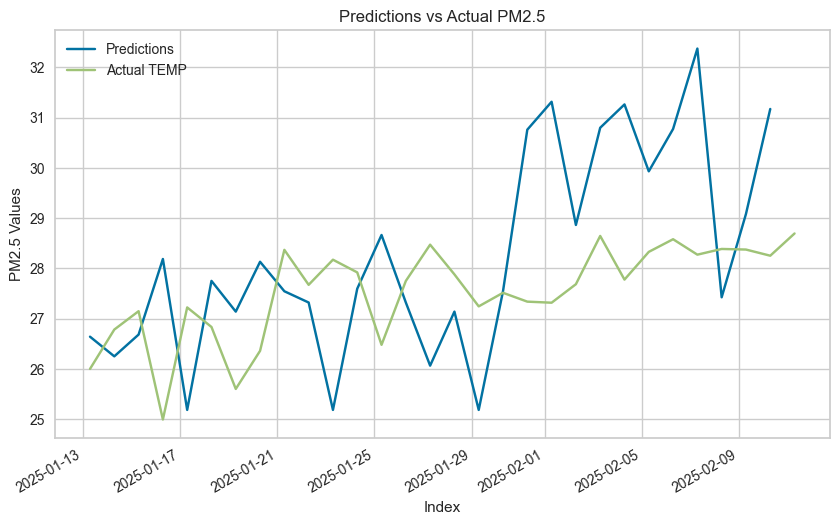

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot = pd.concat([result['prediction_label'].shift(-1), real_data['temperature']], axis=1)
result_plot.columns = ['Predictions', 'Actual TEMP']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result_plot.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual PM2.5')
plt.xlabel('Index')
plt.ylabel('PM2.5 Values')

# แสดงกราฟ
plt.show()

In [ ]:
y_true = test_data["temperature"][:"2025-2-10"]
y_pred = result["prediction_label"].shift(-1).dropna(axis=0)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

R² Score: -4.2227
Mean Absolute Error (MAE): 1.7309
Root Mean Squared Error (RMSE): 2.0940
Mean Absolute Percentage Error (MAPE): 6.30%
Accuracy: 93.70%


In [ ]:
exp1.save_model(model_1, "dt_temp_model_eng")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['date'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['year', 'month', 'day',
                                              'day_of_week', 'week_of_year',
                                              'season', 'is_weekend',
                                              'day_of_year', 'month_sin',
                                              'month_cos', 'day_of_week_sin',
                                              'day_of_week_cos',
                                              'tempera...
                                              'temperature_lag_4',
                                              'temperature_lag_5',
                                              'temperature_lag_6',
                                              'temp

I THINK THAT COMPLETE FOR TEMP  
THE MODEL IS 'rf'
Accuracy(MAPE) = 100 - 2.45 = 97.55 %

Processing model: BayesianRidge


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.1919,1.4207,1.1919,nan,0.0432,0.0458


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.8684,0.7541,0.8684,nan,0.0308,0.0324


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.6483,0.4203,0.6483,nan,0.0228,0.0239


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.0643,9.3899,3.0643,nan,0.1115,0.1226


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.8356,0.6982,0.8356,nan,0.0292,0.0307


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.8182,0.6694,0.8182,nan,0.0290,0.0305


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.1374,4.5683,2.1374,nan,0.0773,0.0835


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.4317,2.0499,1.4317,nan,0.0510,0.0543


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.4785,0.2290,0.4785,nan,0.0164,0.0169


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.2932,0.0860,0.2932,nan,0.0102,0.0106


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.2380,0.0567,0.2380,nan,0.0082,0.0084


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.1129,0.0128,0.1129,nan,0.0039,0.0040


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.2766,1.6297,1.2766,nan,0.0454,0.0482


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.0638,0.0041,0.0638,nan,0.0022,0.0023


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.6553,0.4294,0.6553,nan,0.0225,0.0230


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.0231,0.0005,0.0231,nan,0.0008,0.0008


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.6761,0.4571,0.6761,nan,0.0237,0.0248


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.3191,0.1018,0.3191,nan,0.0111,0.0116


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.3841,0.1475,0.3841,nan,0.0135,0.0141


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.0753,1.1563,1.0753,nan,0.0373,0.0394


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.0502,1.1029,1.0502,nan,0.0360,0.0379


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.2715,0.0737,0.2715,nan,0.0091,0.0095


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.3433,1.8045,1.3433,nan,0.0456,0.0484


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.8456,0.7150,0.8456,nan,0.0284,0.0299


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.5132,0.2633,0.5132,nan,0.0172,0.0180


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.7977,0.6363,0.7977,nan,0.0269,0.0282


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.7154,0.5118,0.7154,nan,0.0241,0.0252


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.8466,0.7167,0.8466,nan,0.0284,0.0298


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.0252,1.0511,1.0252,nan,0.0344,0.0363


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.6956,0.4838,0.6956,nan,0.0232,0.0242


Processing model: Ridge


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.9793,0.9590,0.9793,nan,0.0356,0.0377


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.7148,0.5109,0.7148,nan,0.0254,0.0267


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.5049,0.2549,0.5049,nan,0.0178,0.0186


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.9374,8.6280,2.9374,nan,0.1071,0.1175


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.7149,0.5111,0.7149,nan,0.0250,0.0263


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.6018,0.3622,0.6018,nan,0.0214,0.0224


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.0561,4.2274,2.0561,nan,0.0745,0.0803


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.2725,1.6192,1.2725,nan,0.0455,0.0483


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.6033,0.3640,0.6033,nan,0.0208,0.0213


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.1868,0.0349,0.1868,nan,0.0065,0.0068


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.3854,0.1485,0.3854,nan,0.0133,0.0137


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.3104,0.0963,0.3104,nan,0.0108,0.0111


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.0346,1.0704,1.0346,nan,0.0370,0.0391


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.0881,0.0078,0.0881,nan,0.0031,0.0032


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.8608,0.7409,0.8608,nan,0.0296,0.0302


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.1206,0.0145,0.1206,nan,0.0042,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.5506,0.3031,0.5506,nan,0.0193,0.0202


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.1487,0.0221,0.1487,nan,0.0052,0.0054


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.1790,0.0320,0.1790,nan,0.0063,0.0065


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.8998,0.8096,0.8998,nan,0.0313,0.0329


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.0142,1.0285,1.0142,nan,0.0347,0.0366


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.2080,0.0433,0.2080,nan,0.0070,0.0073


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.3492,1.8202,1.3492,nan,0.0458,0.0486


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.8557,0.7322,0.8557,nan,0.0288,0.0302


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.4519,0.2042,0.4519,nan,0.0152,0.0158


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.6936,0.4811,0.6936,nan,0.0234,0.0245


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.5359,0.2871,0.5359,nan,0.0181,0.0189


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.7432,0.5523,0.7432,nan,0.0250,0.0262


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.8645,0.7473,0.8645,nan,0.0291,0.0306


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.5871,0.3447,0.5871,nan,0.0196,0.0205


Processing model: HuberRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.9148,0.8368,0.9148,nan,0.0333,0.0352


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.3692,0.1363,0.3692,nan,0.0132,0.0138


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.1889,0.0357,0.1889,nan,0.0067,0.0070


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.6457,6.9998,2.6457,nan,0.0969,0.1059


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.6051,0.3662,0.6051,nan,0.0212,0.0222


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.7102,0.5044,0.7102,nan,0.0252,0.0265


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,1.8614,3.4649,1.8614,nan,0.0676,0.0727


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,1.2650,1.6002,1.2650,nan,0.0452,0.0480


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.6993,0.4890,0.6993,nan,0.0241,0.0247


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.0351,0.0012,0.0351,nan,0.0012,0.0013


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.4559,0.2078,0.4559,nan,0.0158,0.0162


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.2807,0.0788,0.2807,nan,0.0098,0.0101


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,1.0505,1.1035,1.0505,nan,0.0375,0.0397


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.2914,0.0849,0.2914,nan,0.0102,0.0105


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.8575,0.7354,0.8575,nan,0.0295,0.0301


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.2070,0.0428,0.2070,nan,0.0072,0.0074


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.4496,0.2021,0.4496,nan,0.0158,0.0165


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.1368,0.0187,0.1368,nan,0.0048,0.0050


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.2144,0.0460,0.2144,nan,0.0075,0.0078


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.7012,0.4916,0.7012,nan,0.0245,0.0257


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.5515,0.3042,0.5515,nan,0.0190,0.0199


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.0064,0.0000,0.0064,nan,0.0002,0.0002


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,1.1117,1.2359,1.1117,nan,0.0379,0.0400


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.6951,0.4831,0.6951,nan,0.0234,0.0245


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.4473,0.2001,0.4473,nan,0.0150,0.0157


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.7295,0.5321,0.7295,nan,0.0246,0.0258


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.5609,0.3147,0.5609,nan,0.0189,0.0198


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.5546,0.3076,0.5546,nan,0.0187,0.0195


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.8909,0.7938,0.8909,nan,0.0300,0.0315


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.5597,0.3132,0.5597,nan,0.0187,0.0195


Processing model: OrthogonalMatchingPursuit


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.7993,0.6388,0.7993,nan,0.0292,0.0307


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.8892,0.7907,0.8892,nan,0.0315,0.0332


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.0831,1.1730,1.0831,nan,0.0378,0.0399


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,3.5972,12.9398,3.5972,nan,0.1296,0.1439


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.5945,2.5424,1.5945,nan,0.0550,0.0586


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.1287,4.5314,2.1287,nan,0.0737,0.0793


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,3.4538,11.9287,3.4538,nan,0.1221,0.1349


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.7523,7.5753,2.7523,nan,0.0959,0.1044


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.7765,0.6029,0.7765,nan,0.0261,0.0274


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.4935,2.2305,1.4935,nan,0.0508,0.0540


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.0048,1.0096,1.0048,nan,0.0339,0.0357


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.2634,1.5961,1.2634,nan,0.0428,0.0453


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.7067,7.3261,2.7067,nan,0.0940,0.1022


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.4345,2.0579,1.4345,nan,0.0487,0.0517


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.7102,0.5043,0.7102,nan,0.0238,0.0249


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.2986,1.6865,1.2986,nan,0.0440,0.0466


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.9314,3.7302,1.9314,nan,0.0661,0.0709


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.6569,2.7454,1.6569,nan,0.0565,0.0602


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.8286,3.3439,1.8286,nan,0.0625,0.0669


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.8453,3.4050,1.8453,nan,0.0631,0.0676


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.4720,2.1667,1.4720,nan,0.0500,0.0532


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.5065,0.2565,0.5065,nan,0.0169,0.0177


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.3707,1.8787,1.3707,nan,0.0465,0.0493


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.8137,0.6621,0.8137,nan,0.0274,0.0287


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.5570,0.3103,0.5570,nan,0.0187,0.0195


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.8593,0.7384,0.8593,nan,0.0289,0.0304


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.7407,0.5486,0.7407,nan,0.0249,0.0261


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.7475,0.5588,0.7475,nan,0.0251,0.0263


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.8651,0.7484,0.8651,nan,0.0291,0.0306


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.4175,0.1743,0.4175,nan,0.0140,0.0146


Processing model: RandomForestRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.4477,2.0959,1.4477,nan,0.0522,0.0557


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.9221,0.8503,0.9221,nan,0.0327,0.0344


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0055,0.0000,0.0055,nan,0.0002,0.0002


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.5788,6.6502,2.5788,nan,0.0946,0.1032


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.3399,0.1155,0.3399,nan,0.0120,0.0125


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.6590,0.4343,0.6590,nan,0.0234,0.0246


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.2092,4.8805,2.2092,nan,0.0798,0.0863


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.5308,2.3435,1.5308,nan,0.0544,0.0581


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.7010,0.4914,0.7010,nan,0.0242,0.0247


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0575,0.0033,0.0575,nan,0.0020,0.0021


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.4495,0.2020,0.4495,nan,0.0155,0.0160


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.2568,0.0660,0.2568,nan,0.0089,0.0092


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.1777,1.3870,1.1777,nan,0.0420,0.0445


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0912,0.0083,0.0912,nan,0.0032,0.0033


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.7501,0.5627,0.7501,nan,0.0258,0.0263


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.2172,0.0472,0.2172,nan,0.0076,0.0078


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.3616,0.1308,0.3616,nan,0.0127,0.0133


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.1150,0.0132,0.1150,nan,0.0040,0.0042


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.3987,0.1589,0.3987,nan,0.0140,0.0146


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.7374,0.5437,0.7374,nan,0.0257,0.0270


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.4666,0.2177,0.4666,nan,0.0161,0.0169


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.5324,0.2834,0.5324,nan,0.0181,0.0186


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.2773,0.0769,0.2773,nan,0.0096,0.0100


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.3066,0.0940,0.3066,nan,0.0105,0.0108


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.4830,0.2333,0.4830,nan,0.0165,0.0169


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.1540,0.0237,0.1540,nan,0.0053,0.0054


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.2553,0.0652,0.2553,nan,0.0087,0.0090


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.2283,0.0521,0.2283,nan,0.0078,0.0080


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.1202,0.0144,0.1202,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.6496,0.4219,0.6496,nan,0.0221,0.0226


Processing model: ExtraTreesRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.4133,1.9975,1.4133,nan,0.0510,0.0544


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.8300,0.6889,0.8300,nan,0.0294,0.0310


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.2074,0.0430,0.2074,nan,0.0073,0.0076


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2.4563,6.0334,2.4563,nan,0.0903,0.0983


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1886,0.0356,0.1886,nan,0.0067,0.0069


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.7528,0.5667,0.7528,nan,0.0267,0.0281


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2.3744,5.6380,2.3744,nan,0.0855,0.0928


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.6028,2.5689,1.6028,nan,0.0569,0.0608


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.4974,0.2474,0.4974,nan,0.0171,0.0175


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0784,0.0061,0.0784,nan,0.0027,0.0028


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.4384,0.1922,0.4384,nan,0.0151,0.0156


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.2629,0.0691,0.2629,nan,0.0091,0.0094


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.1321,1.2816,1.1321,nan,0.0404,0.0428


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1639,0.0269,0.1639,nan,0.0057,0.0059


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.7635,0.5829,0.7635,nan,0.0262,0.0268


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.2961,0.0877,0.2961,nan,0.0103,0.0106


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.2324,0.0540,0.2324,nan,0.0082,0.0085


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0026,0.0000,0.0026,nan,0.0001,0.0001


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1638,0.0268,0.1638,nan,0.0058,0.0060


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.5513,0.3040,0.5513,nan,0.0193,0.0202


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.2487,0.0618,0.2487,nan,0.0086,0.0090


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.7148,0.5109,0.7148,nan,0.0244,0.0250


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1588,0.0252,0.1588,nan,0.0055,0.0057


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.3527,0.1244,0.3527,nan,0.0121,0.0125


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.5109,0.2610,0.5109,nan,0.0174,0.0179


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0810,0.0066,0.0810,nan,0.0028,0.0029


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0246,0.0006,0.0246,nan,0.0008,0.0009


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0936,0.0088,0.0936,nan,0.0032,0.0033


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0129,0.0002,0.0129,nan,0.0004,0.0005


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.5508,0.3034,0.5508,nan,0.0187,0.0192


Processing model: AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,1.4047,1.9733,1.4047,nan,0.0507,0.0540


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.7580,0.5746,0.7580,nan,0.0269,0.0283


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.2783,0.0774,0.2783,nan,0.0098,0.0103


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,2.4439,5.9726,2.4439,nan,0.0899,0.0978


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.1804,0.0325,0.1804,nan,0.0064,0.0066


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.5696,0.3245,0.5696,nan,0.0203,0.0212


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,1.9401,3.7640,1.9401,nan,0.0704,0.0758


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,1.1602,1.3461,1.1602,nan,0.0415,0.0440


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.8505,0.7233,0.8505,nan,0.0294,0.0300


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.1541,0.0237,0.1541,nan,0.0054,0.0056


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.6543,0.4281,0.6543,nan,0.0227,0.0232


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.4013,0.1610,0.4013,nan,0.0140,0.0144


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,1.0402,1.0821,1.0402,nan,0.0372,0.0393


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.2099,0.0441,0.2099,nan,0.0073,0.0076


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.9321,0.8688,0.9321,nan,0.0321,0.0327


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.3404,0.1159,0.3404,nan,0.0119,0.0122


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.2961,0.0877,0.2961,nan,0.0104,0.0109


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.0259,0.0007,0.0259,nan,0.0009,0.0009


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.2022,0.0409,0.2022,nan,0.0071,0.0074


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.7190,0.5169,0.7190,nan,0.0251,0.0263


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.3841,0.1476,0.3841,nan,0.0133,0.0139


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.5765,0.3324,0.5765,nan,0.0196,0.0201


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.3125,0.0976,0.3125,nan,0.0108,0.0112


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.1012,0.0102,0.1012,nan,0.0035,0.0036


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.3530,0.1246,0.3530,nan,0.0120,0.0124


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.2376,0.0564,0.2376,nan,0.0081,0.0084


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.3950,0.1560,0.3950,nan,0.0135,0.0139


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.3759,0.1413,0.3759,nan,0.0129,0.0132


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.2534,0.0642,0.2534,nan,0.0087,0.0090


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.6960,0.4844,0.6960,nan,0.0237,0.0243


Processing model: KNeighborsRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,1.7028,2.8995,1.7028,nan,0.0612,0.0655


  File "d:\Normal File\Coder\MINI_PROJECT_1-2\pycaret_venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,1.0142,1.0285,1.0142,nan,0.0359,0.0379


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.6483,0.4203,0.6483,nan,0.0228,0.0239


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,2.8602,8.1810,2.8602,nan,0.1044,0.1145


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.6987,0.4882,0.6987,nan,0.0245,0.0257


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,1.0665,1.1374,1.0665,nan,0.0376,0.0397


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,2.4363,5.9354,2.4363,nan,0.0876,0.0952


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,1.2156,1.4776,1.2156,nan,0.0435,0.0461


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.9895,0.9790,0.9895,nan,0.0343,0.0349


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.2303,0.0530,0.2303,nan,0.0081,0.0083


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.9429,0.8891,0.9429,nan,0.0329,0.0335


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,1.0122,1.0246,1.0122,nan,0.0356,0.0363


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.6132,0.3760,0.6132,nan,0.0221,0.0232


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.6583,0.4334,0.6583,nan,0.0232,0.0237


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,1.1041,1.2190,1.1041,nan,0.0382,0.0388


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.3461,0.1198,0.3461,nan,0.0121,0.0124


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.2606,0.0679,0.2606,nan,0.0092,0.0096


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.0096,0.0001,0.0096,nan,0.0003,0.0003


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.0242,0.0006,0.0242,nan,0.0009,0.0009


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.5244,0.2750,0.5244,nan,0.0184,0.0192


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.1560,0.0243,0.1560,nan,0.0054,0.0056


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.8047,0.6475,0.8047,nan,0.0275,0.0281


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.0644,0.0041,0.0644,nan,0.0022,0.0023


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.4876,0.2378,0.4876,nan,0.0168,0.0172


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.5675,0.3221,0.5675,nan,0.0194,0.0199


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.0847,0.0072,0.0847,nan,0.0029,0.0030


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.1984,0.0394,0.1984,nan,0.0068,0.0070


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.1739,0.0302,0.1739,nan,0.0059,0.0061


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.0514,0.0026,0.0514,nan,0.0018,0.0018


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.5253,0.2759,0.5253,nan,0.0178,0.0183


Processing model: GradientBoostingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.5494,2.4005,1.5494,nan,0.0558,0.0596


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.2919,1.6691,1.2919,nan,0.0455,0.0482


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.4412,0.1947,0.4412,nan,0.0158,0.0163


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2.0251,4.1011,2.0251,nan,0.0750,0.0810


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.7908,0.6253,0.7908,nan,0.0276,0.0290


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.6661,0.4437,0.6661,nan,0.0237,0.0248


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2.2279,4.9636,2.2279,nan,0.0804,0.0870


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.6904,2.8576,1.6904,nan,0.0600,0.0641


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.6146,0.3777,0.6146,nan,0.0211,0.0217


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.0842,0.0071,0.0842,nan,0.0029,0.0030


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.2989,0.0894,0.2989,nan,0.0103,0.0106


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.2657,0.0706,0.2657,nan,0.0092,0.0095


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.2354,1.5262,1.2354,nan,0.0440,0.0467


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.1569,0.0246,0.1569,nan,0.0055,0.0057


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.8032,0.6451,0.8032,nan,0.0276,0.0282


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.2310,0.0534,0.2310,nan,0.0080,0.0083


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.4425,0.1958,0.4425,nan,0.0155,0.0162


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.1379,0.0190,0.1379,nan,0.0048,0.0050


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.3450,0.1191,0.3450,nan,0.0121,0.0126


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.7242,0.5244,0.7242,nan,0.0253,0.0265


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.3683,0.1357,0.3683,nan,0.0128,0.0133


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.4482,0.2009,0.4482,nan,0.0152,0.0156


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.4482,0.2009,0.4482,nan,0.0155,0.0161


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.1709,0.0292,0.1709,nan,0.0058,0.0060


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.4174,0.1742,0.4174,nan,0.0142,0.0146


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.1101,0.0121,0.1101,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.2380,0.0566,0.2380,nan,0.0081,0.0084


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.2261,0.0511,0.2261,nan,0.0077,0.0080


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.1036,0.0107,0.1036,nan,0.0035,0.0037


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.5684,0.3231,0.5684,nan,0.0193,0.0198


Processing model: ElasticNet


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.2142,4.9029,2.2142,nan,0.0788,0.0852


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.0055,4.0221,2.0055,nan,0.0697,0.0749


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.9235,3.6997,1.9235,nan,0.0661,0.0709


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,4.2014,17.6521,4.2014,nan,0.1498,0.1681


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.9935,3.9740,1.9935,nan,0.0683,0.0732


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.2910,5.2487,2.2910,nan,0.0791,0.0854


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,3.5903,12.8903,3.5903,nan,0.1266,0.1403


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.8587,8.1724,2.8587,nan,0.0994,0.1085


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,0.8632,0.7452,0.8632,nan,0.0290,0.0304


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.5640,2.4462,1.5640,nan,0.0531,0.0565


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.0614,1.1265,1.0614,nan,0.0357,0.0377


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.3055,1.7044,1.3055,nan,0.0442,0.0468


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.7414,7.5154,2.7414,nan,0.0951,0.1035


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.4635,2.1419,1.4635,nan,0.0497,0.0527


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,0.7345,0.5395,0.7345,nan,0.0246,0.0258


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.3188,1.7394,1.3188,nan,0.0447,0.0473


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.9477,3.7934,1.9477,nan,0.0667,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.6694,2.7868,1.6694,nan,0.0569,0.0607


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.8375,3.3764,1.8375,nan,0.0628,0.0672


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.9159,3.6705,1.9159,nan,0.0655,0.0701


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.5568,2.4236,1.5568,nan,0.0529,0.0562


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,0.5962,0.3555,0.5962,nan,0.0199,0.0208


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.4603,2.1326,1.4603,nan,0.0495,0.0526


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,0.9014,0.8125,0.9014,nan,0.0303,0.0318


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,0.6420,0.4121,0.6420,nan,0.0215,0.0225


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,0.9434,0.8900,0.9434,nan,0.0317,0.0334


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,0.8228,0.6769,0.8228,nan,0.0276,0.0290


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,0.8271,0.6841,0.8271,nan,0.0278,0.0292


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,0.9418,0.8869,0.9418,nan,0.0317,0.0333


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,0.4911,0.2412,0.4911,nan,0.0164,0.0171


Processing model: LGBMRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.1591,1.3435,1.1591,nan,0.0420,0.0446


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.4537,0.2058,0.4537,nan,0.0162,0.0169


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0684,0.0047,0.0684,nan,0.0024,0.0025


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0282,4.1136,2.0282,nan,0.0751,0.0812


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0610,0.0037,0.0610,nan,0.0022,0.0022


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.4409,0.1944,0.4409,nan,0.0157,0.0164


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.9277,3.7159,1.9277,nan,0.0700,0.0753


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.1860,1.4065,1.1860,nan,0.0424,0.0450


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.8080,0.6529,0.8080,nan,0.0279,0.0285


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.4076,0.1661,0.4076,nan,0.0143,0.0147


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.0596,1.1227,1.0596,nan,0.0370,0.0376


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.8266,0.6832,0.8266,nan,0.0290,0.0296


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.6929,0.4801,0.6929,nan,0.0249,0.0262


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.6280,0.3944,0.6280,nan,0.0221,0.0226


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.1297,1.2763,1.1297,nan,0.0391,0.0397


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.5697,0.3245,0.5697,nan,0.0199,0.0204


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0931,0.0087,0.0931,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.3156,0.0996,0.3156,nan,0.0111,0.0115


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0604,0.0036,0.0604,nan,0.0021,0.0022


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.5175,0.2678,0.5175,nan,0.0181,0.0189


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.3112,0.0968,0.3112,nan,0.0108,0.0112


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.8665,0.7509,0.8665,nan,0.0297,0.0303


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2772,0.0768,0.2772,nan,0.0096,0.0100


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.3488,0.1216,0.3488,nan,0.0120,0.0123


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.4119,0.1697,0.4119,nan,0.0140,0.0144


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0166,0.0003,0.0166,nan,0.0006,0.0006


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1052,0.0111,0.1052,nan,0.0036,0.0037


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0216,0.0005,0.0216,nan,0.0007,0.0008


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0345,0.0012,0.0345,nan,0.0012,0.0012


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.5029,0.2529,0.5029,nan,0.0171,0.0175


Processing model: Lasso


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,2.7840,7.7506,2.7840,nan,0.0981,0.1071


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,2.4497,6.0011,2.4497,nan,0.0845,0.0915


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,2.1405,4.5818,2.1405,nan,0.0733,0.0788


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,4.3000,18.4903,4.3000,nan,0.1531,0.1721


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,2.0652,4.2649,2.0652,nan,0.0706,0.0759


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,2.4496,6.0006,2.4496,nan,0.0844,0.0913


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,3.6783,13.5302,3.6783,nan,0.1295,0.1437


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,2.9149,8.4969,2.9149,nan,0.1012,0.1106


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,0.8993,0.8087,0.8993,nan,0.0302,0.0317


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.5907,2.5304,1.5907,nan,0.0540,0.0575


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.0856,1.1786,1.0856,nan,0.0365,0.0385


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.3337,1.7788,1.3337,nan,0.0451,0.0478


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,2.7702,7.6743,2.7702,nan,0.0961,0.1046


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.4938,2.2314,1.4938,nan,0.0507,0.0538


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,0.7666,0.5877,0.7666,nan,0.0257,0.0269


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.3534,1.8316,1.3534,nan,0.0458,0.0485


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.9850,3.9402,1.9850,nan,0.0679,0.0729


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.7098,2.9236,1.7098,nan,0.0582,0.0621


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.8811,3.5386,1.8811,nan,0.0643,0.0688


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.8975,3.6005,1.8975,nan,0.0649,0.0695


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.5241,2.3228,1.5241,nan,0.0518,0.0551


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,0.5585,0.3119,0.5585,nan,0.0187,0.0195


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.4226,2.0239,1.4226,nan,0.0483,0.0512


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,0.8657,0.7494,0.8657,nan,0.0291,0.0306


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,0.6090,0.3709,0.6090,nan,0.0204,0.0213


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,0.9113,0.8305,0.9113,nan,0.0307,0.0322


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,0.7927,0.6284,0.7927,nan,0.0266,0.0279


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,0.7996,0.6394,0.7996,nan,0.0269,0.0282


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,0.9172,0.8413,0.9172,nan,0.0309,0.0325


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,0.4697,0.2206,0.4697,nan,0.0157,0.0164


Processing model: LassoLars


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,2.7840,7.7505,2.7840,nan,0.0981,0.1071


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,2.4497,6.0011,2.4497,nan,0.0845,0.0915


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,2.1405,4.5817,2.1405,nan,0.0733,0.0788


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,4.3000,18.4902,4.3000,nan,0.1531,0.1721


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,2.0652,4.2649,2.0652,nan,0.0706,0.0759


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,2.4496,6.0005,2.4496,nan,0.0844,0.0913


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,3.6783,13.5301,3.6783,nan,0.1295,0.1437


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,2.9149,8.4969,2.9149,nan,0.1012,0.1106


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,0.8993,0.8087,0.8993,nan,0.0302,0.0317


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.5907,2.5304,1.5907,nan,0.0540,0.0575


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.0856,1.1786,1.0856,nan,0.0365,0.0385


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.3337,1.7787,1.3337,nan,0.0451,0.0478


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,2.7702,7.6743,2.7702,nan,0.0961,0.1046


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.4938,2.2313,1.4938,nan,0.0507,0.0538


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,0.7666,0.5877,0.7666,nan,0.0257,0.0269


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.3534,1.8316,1.3534,nan,0.0458,0.0485


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.9850,3.9402,1.9850,nan,0.0679,0.0729


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.7098,2.9236,1.7098,nan,0.0582,0.0621


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.8811,3.5386,1.8811,nan,0.0643,0.0688


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.8975,3.6005,1.8975,nan,0.0649,0.0695


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.5241,2.3228,1.5241,nan,0.0518,0.0551


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,0.5585,0.3119,0.5585,nan,0.0187,0.0195


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.4226,2.0239,1.4226,nan,0.0483,0.0512


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,0.8657,0.7494,0.8657,nan,0.0291,0.0306


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,0.6090,0.3709,0.6090,nan,0.0204,0.0213


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,0.9113,0.8305,0.9113,nan,0.0307,0.0322


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,0.7927,0.6284,0.7927,nan,0.0266,0.0279


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,0.7996,0.6394,0.7996,nan,0.0269,0.0282


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,0.9172,0.8413,0.9172,nan,0.0309,0.0325


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,0.4697,0.2206,0.4697,nan,0.0157,0.0164


Processing model: DummyRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,2.3391,5.4716,2.3391,nan,0.0831,0.0900


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,1.5556,2.4199,1.5556,nan,0.0545,0.0581


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,1.1898,1.4155,1.1898,nan,0.0414,0.0438


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,3.3459,11.1949,3.3459,nan,0.1211,0.1339


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,1.1148,1.2428,1.1148,nan,0.0387,0.0410


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,1.5040,2.2622,1.5040,nan,0.0526,0.0561


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,2.7377,7.4950,2.7377,nan,0.0980,0.1069


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,1.9792,3.9174,1.9792,nan,0.0699,0.0751


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,0.0315,0.0010,0.0315,nan,0.0011,0.0011


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,0.6649,0.4421,0.6649,nan,0.0229,0.0240


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,0.1647,0.0271,0.1647,nan,0.0056,0.0058


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,0.4178,0.1745,0.4178,nan,0.0143,0.0150


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,1.8593,3.4568,1.8593,nan,0.0655,0.0702


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,0.5877,0.3454,0.5877,nan,0.0202,0.0212


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,0.1345,0.0181,0.1345,nan,0.0046,0.0047


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,0.4572,0.2090,0.4572,nan,0.0157,0.0164


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,1.0938,1.1963,1.0938,nan,0.0380,0.0401


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,0.8236,0.6782,0.8236,nan,0.0285,0.0299


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,0.9998,0.9995,0.9998,nan,0.0347,0.0366


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,1.0211,1.0426,1.0211,nan,0.0354,0.0374


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,0.6526,0.4259,0.6526,nan,0.0225,0.0236


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,0.3081,0.0949,0.3081,nan,0.0104,0.0108


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,0.5611,0.3148,0.5611,nan,0.0193,0.0202


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,0.0090,0.0001,0.0090,nan,0.0003,0.0003


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,0.2427,0.0589,0.2427,nan,0.0082,0.0085


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,0.0646,0.0042,0.0646,nan,0.0022,0.0023


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,0.0491,0.0024,0.0491,nan,0.0017,0.0017


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,0.0373,0.0014,0.0373,nan,0.0013,0.0013


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,0.0853,0.0073,0.0853,nan,0.0029,0.0030


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,0.3573,0.1277,0.3573,nan,0.0121,0.0125


Processing model: DecisionTreeRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,2.0187,4.0750,2.0187,nan,0.0721,0.0776


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.9646,0.9305,0.9646,nan,0.0341,0.0360


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.4751,0.2257,0.4751,nan,0.0167,0.0175


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,3.1811,10.1196,3.1811,nan,0.1155,0.1273


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.8748,0.7653,0.8748,nan,0.0305,0.0321


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.6512,2.7263,1.6512,nan,0.0612,0.0615


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.9932,0.9864,0.9932,nan,0.0367,0.0388


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.8478,0.7188,0.8478,nan,0.0305,0.0322


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.2374,0.0563,0.2374,nan,0.0081,0.0084


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.0740,0.0055,0.0740,nan,0.0026,0.0027


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,2.7374,7.4936,2.7374,nan,0.0994,0.0981


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.9451,3.7833,1.9451,nan,0.0684,0.0735


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.0033,0.0000,0.0033,nan,0.0001,0.0001


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.1342,1.2865,1.1342,nan,0.0392,0.0398


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.2924,0.0855,0.2924,nan,0.0101,0.0105


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.5028,0.2528,0.5028,nan,0.0176,0.0185


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.8207,0.6735,0.8207,nan,0.0292,0.0298


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.0000,0.0000,0.0000,nan,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.1104,0.0122,0.1104,nan,0.0039,0.0040


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.1928,0.0372,0.1928,nan,0.0067,0.0070


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.4728,0.2235,0.4728,nan,0.0161,0.0165


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.0531,0.0028,0.0531,nan,0.0018,0.0019


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.2651,0.0703,0.2651,nan,0.0091,0.0094


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.6605,0.4362,0.6605,nan,0.0226,0.0231


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.4759,0.2265,0.4759,nan,0.0164,0.0168


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.3062,0.0937,0.3062,nan,0.0105,0.0108


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.0626,0.0039,0.0626,nan,0.0021,0.0022


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.4226,0.1786,0.4226,nan,0.0146,0.0150


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.2222,0.0494,0.2222,nan,0.0075,0.0077


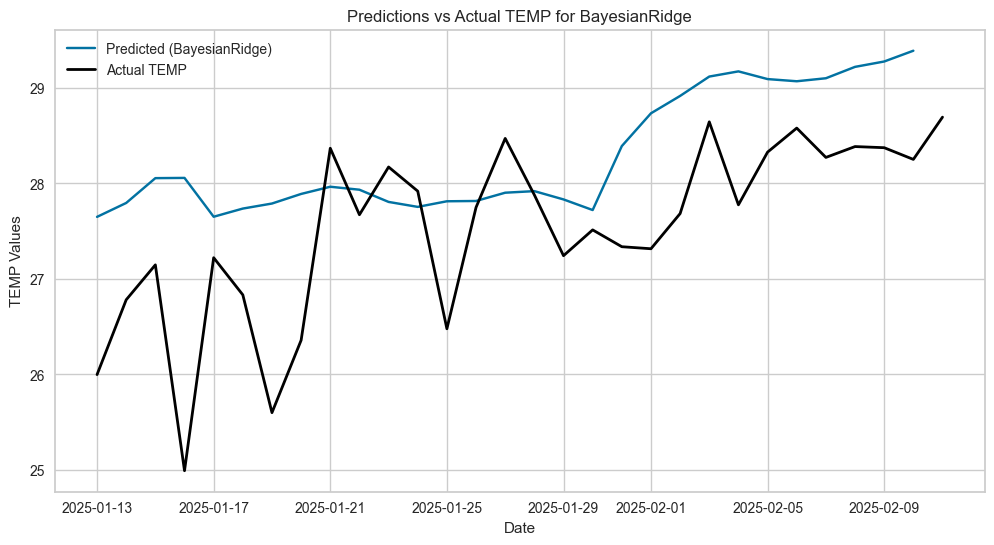

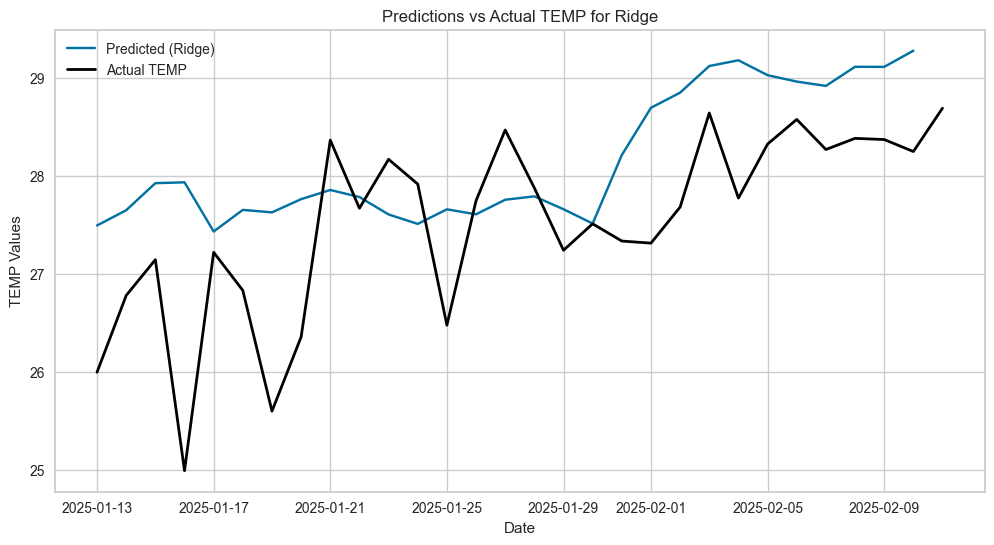

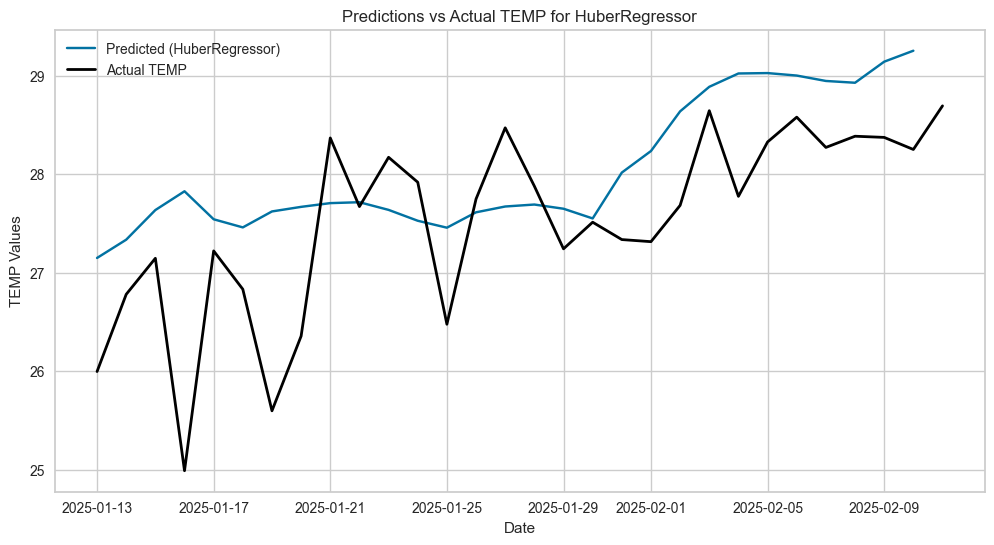

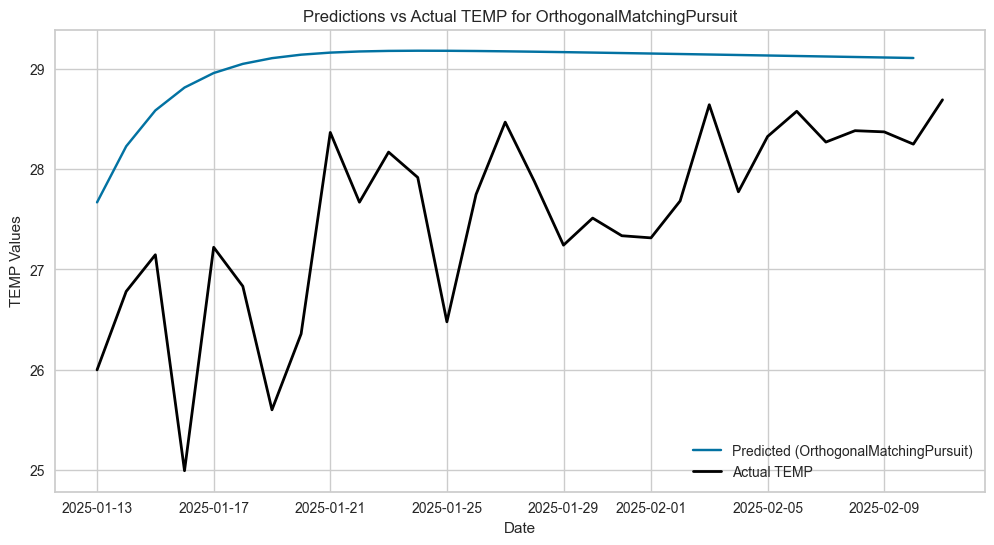

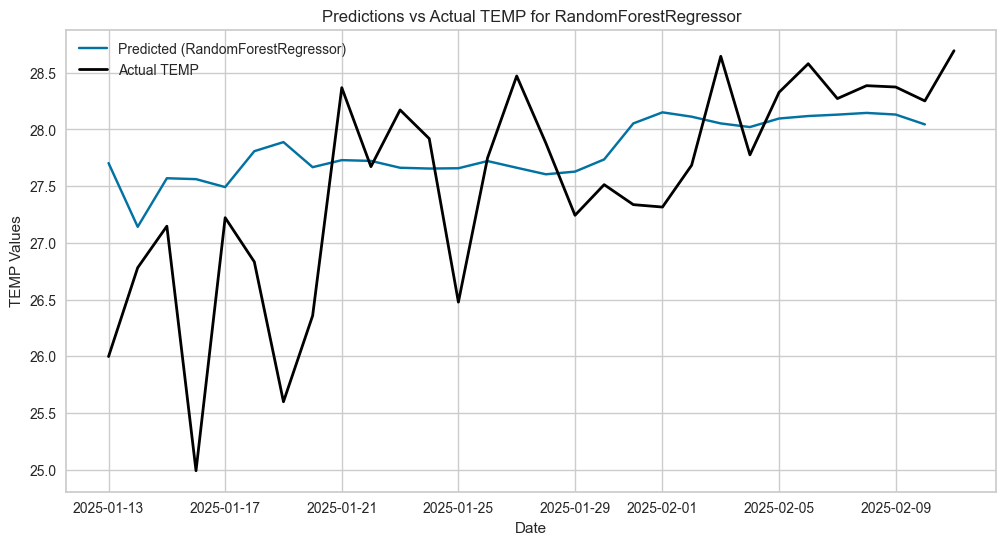

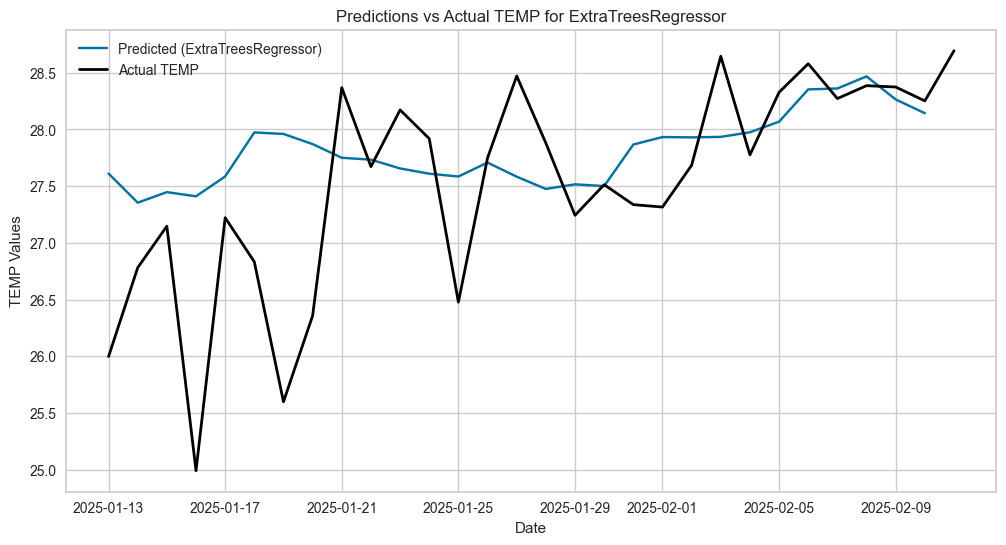

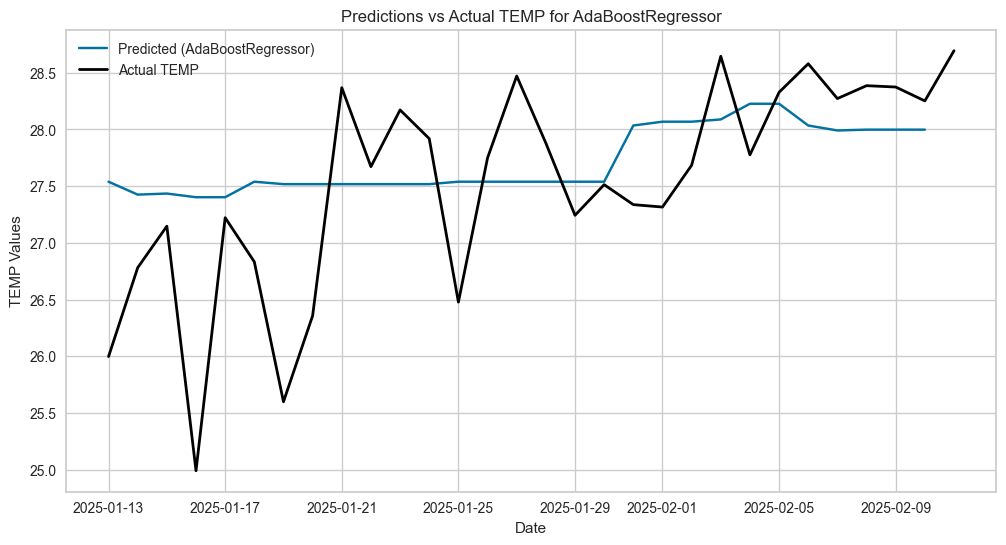

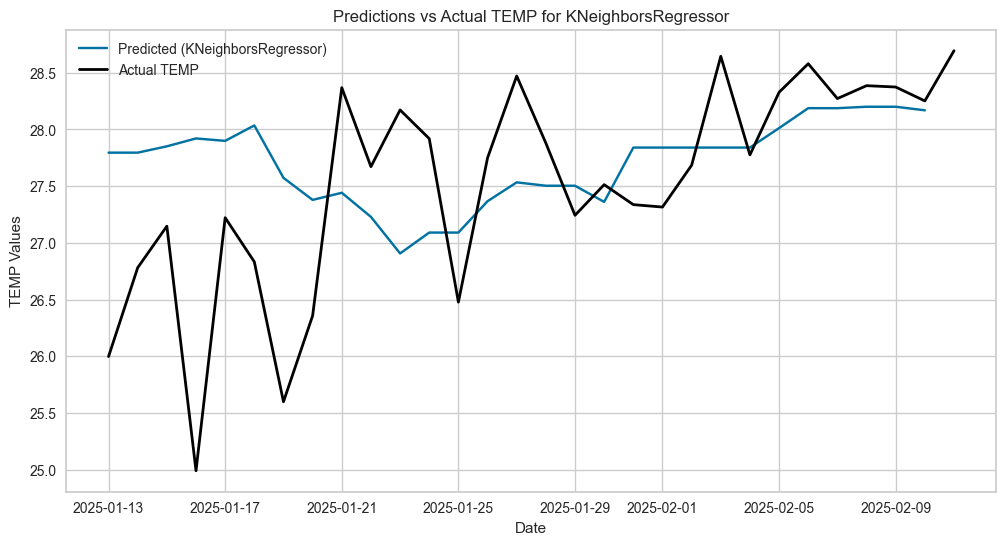

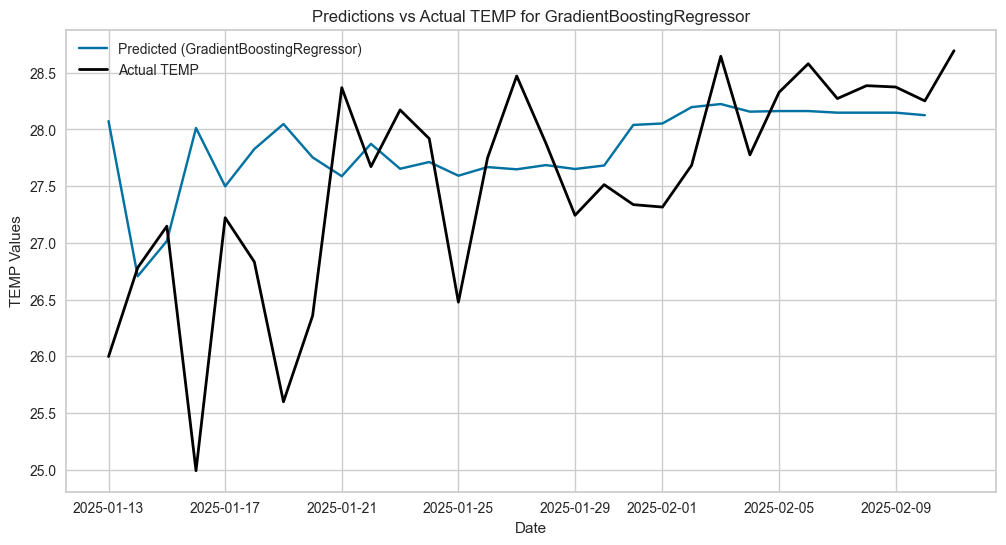

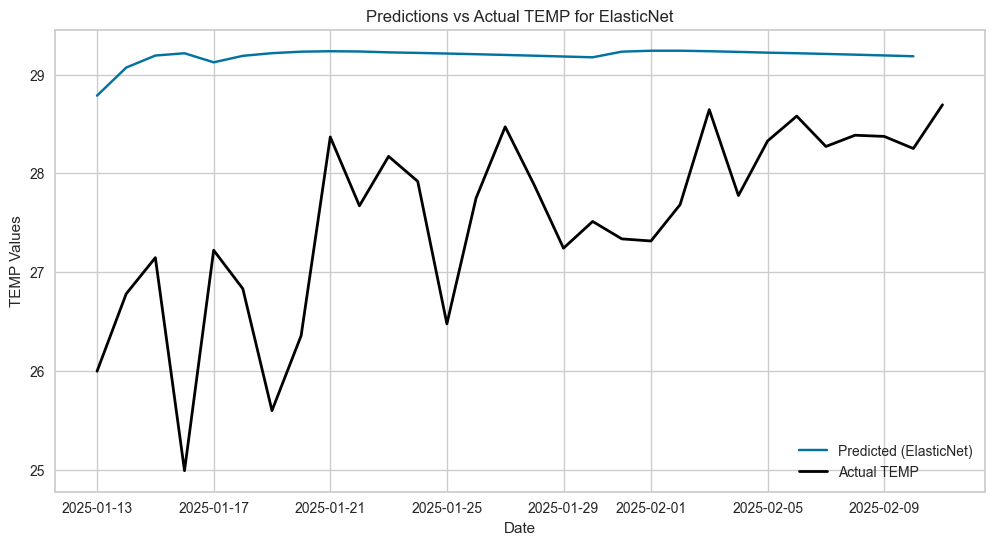

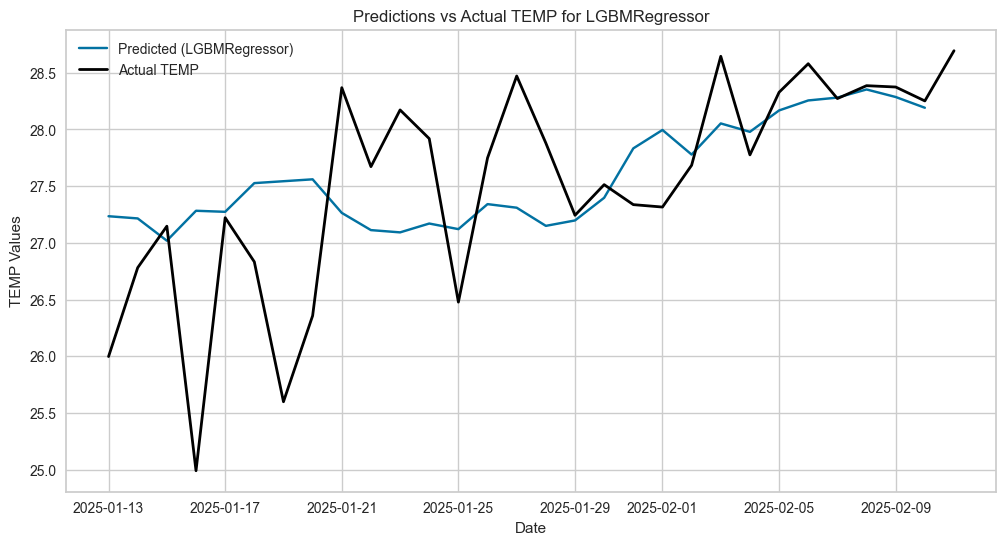

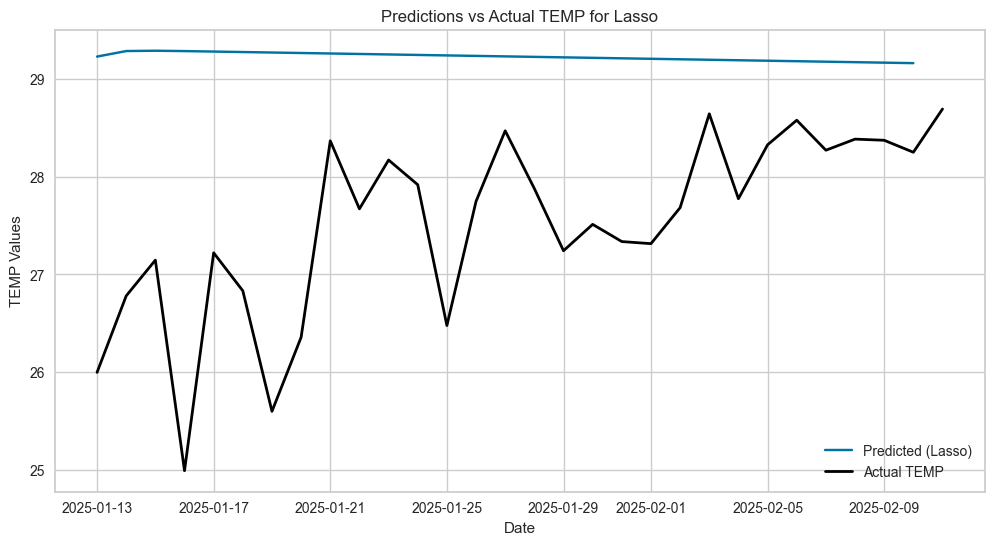

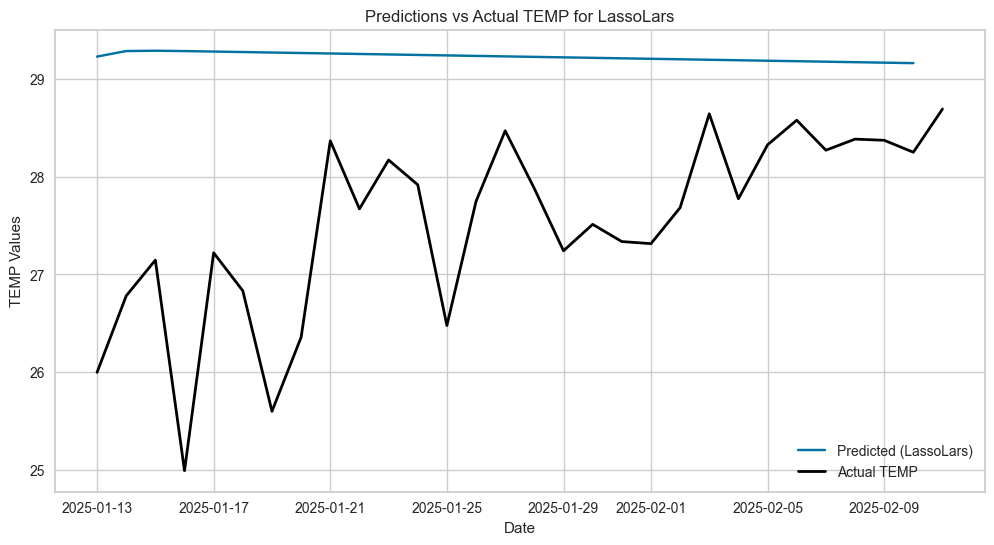

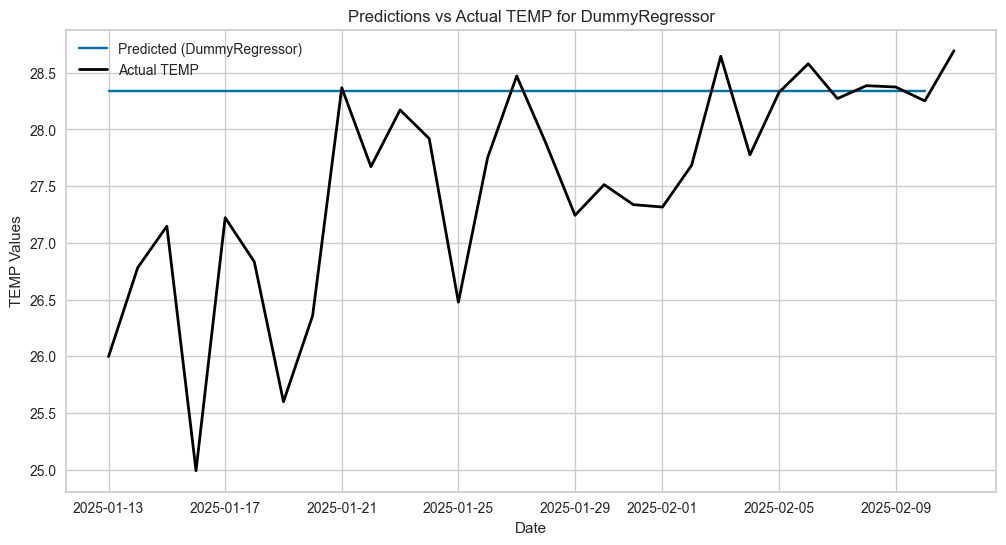

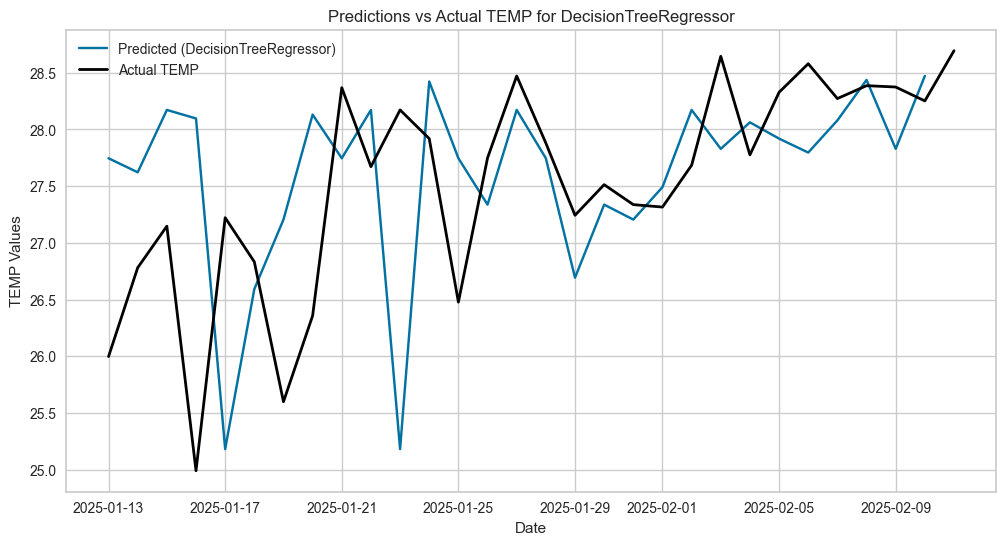

In [108]:
import pandas as pd
import matplotlib.pyplot as plt

# แปลง index เป็น datetime และลบเวลาออก
x = data_filtered.copy()
x.index = pd.to_datetime(x.index).normalize()

# เก็บผลลัพธ์ของแต่ละโมเดล
result_dict = {}

# รายชื่อโมเดลทั้งหมดจาก best_list
model_names = {model.__class__.__name__: model for model in best}

start_date = "2025-01-13"
end_date = "2025-02-11"

# วนลูปผ่านทุกโมเดล
for model_name, model in model_names.items():
    print(f"Processing model: {model_name}")

    data_compare = x.loc[:'2025-01-12'].copy()  # ใช้ copy() ป้องกัน Warning
    result = pd.DataFrame()

    for date in pd.date_range(start=start_date, end=end_date, freq="D"):
        # ลบเวลาออกจากวันที่
        date = pd.to_datetime(date).normalize()  # ลบเวลาออกจากตัวแปร date

        # ตรวจสอบว่าใน x มีข้อมูลในวันที่นี้หรือไม่
        if date not in x.index:
            print(f"⚠️ Warning: Date {date} not found in x index.")
            continue

        # ดึงข้อมูลของวันที่ต้องการ
        test_1 = x.loc[[date]].copy()

        # ใส่เข้าไป
        data_compare = pd.concat([data_compare, test_1], axis=0)

        # เพิ่ม lag feature
        for i in range(1, lag_size + 1):
            test_1[f'temperature_lag_{i}'] = data_compare['temperature'].shift(i).iloc[-1]

        # ลบค่า NaN ที่เกิดจากการ shift
        test_1 = test_1.dropna()

        # ทำนายค่า
        predict_test_1 = exp1.predict_model(model, data=test_1)

        # อัปเดต data_compare
        predict_test_1.index = [date]  # กำหนด index เป็นวันที่พยากรณ์
        data_compare.loc[date, 'temperature'] = predict_test_1['prediction_label'].values[0]

        # บันทึกผลลัพธ์
        result = pd.concat([result, predict_test_1], axis=0)

    # บันทึกผลลัพธ์ของโมเดลนี้ลง dict
    result_dict[model_name] = result

# --------------------------------------------
# พล็อตกราฟเปรียบเทียบทุกโมเดล
# --------------------------------------------
real_data = x.loc[start_date:end_date]

# วนลูปพล็อตกราฟทีละโมเดล
for model_name, result in result_dict.items():
    plt.figure(figsize=(12, 6))
    
    result_plot = pd.concat([result['prediction_label'].shift(-1), real_data['temperature']], axis=1)
    result_plot.columns = ['Predictions', 'Actual TEMP']

    plt.plot(result_plot.index, result_plot['Predictions'], label=f"Predicted ({model_name})")
    plt.plot(real_data.index, real_data['temperature'], label="Actual TEMP", color="black", linewidth=2)
    
    # ตั้งค่ากราฟ
    plt.title(f'Predictions vs Actual TEMP for {model_name}')
    plt.xlabel('Date')
    plt.ylabel('TEMP Values')
    plt.legend()

    # แสดงกราฟ
    plt.show()

In [109]:
# --------------------------------------------
# คำนวณและแสดงผล Regression Metrics (หลังจากพล็อตกราฟ)
# --------------------------------------------
for model_name, result in result_dict.items():
    y_true = x.loc[start_date:end_date, 'temperature'][:'2025-2-10']  # ค่าจริง
    y_pred = result['prediction_label'].shift(-1)  # ค่าพยากรณ์

    # ลบ NaN ที่เกิดจากการ shift
    valid_idx = y_pred.dropna().index
    y_true = y_true.loc[valid_idx]
    y_pred = y_pred.loc[valid_idx]

    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
    accuracy = 100 - mape  # เปลี่ยนเป็น Accuracy %

    # แสดงค่า Metrics ของโมเดลนี้
    print("\n📊 Model Performance Metrics:")
    print(f"Model: {model_name}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Accuracy: {accuracy:.2f}%")
    print("-" * 50)


📊 Model Performance Metrics:
Model: BayesianRidge
R² Score: -0.4855
Mean Absolute Error (MAE): 0.9047
Root Mean Squared Error (RMSE): 1.1168
Mean Absolute Percentage Error (MAPE): 3.36%
Accuracy: 96.64%
--------------------------------------------------

📊 Model Performance Metrics:
Model: Ridge
R² Score: -0.2920
Mean Absolute Error (MAE): 0.8368
Root Mean Squared Error (RMSE): 1.0415
Mean Absolute Percentage Error (MAPE): 3.10%
Accuracy: 96.90%
--------------------------------------------------

📊 Model Performance Metrics:
Model: HuberRegressor
R² Score: -0.0585
Mean Absolute Error (MAE): 0.7464
Root Mean Squared Error (RMSE): 0.9427
Mean Absolute Percentage Error (MAPE): 2.77%
Accuracy: 97.23%
--------------------------------------------------

📊 Model Performance Metrics:
Model: OrthogonalMatchingPursuit
R² Score: -2.6012
Mean Absolute Error (MAE): 1.5343
Root Mean Squared Error (RMSE): 1.7388
Mean Absolute Percentage Error (MAPE): 5.68%
Accuracy: 94.32%
--------------------------